In [1]:
#Importing required libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import cm
import scipy.io
import cv2

In [2]:
r1_path = 'Recording-1.png'
r2_path = 'Recording-2.png'

#Reading the images using OpenCV
r1_im = cv2.imread(r1_path, cv2.IMREAD_GRAYSCALE)
r2_im = cv2.imread(r2_path, cv2.IMREAD_GRAYSCALE)

#Converting the images to arrays and finding their resolution
r1_arr = np.array(r1_im)
im_h = r1_arr.shape[0]
im_w = r1_arr.shape[1]
r2_arr = np.array(r2_im)

#Flattening the images and finding their means
r1_vect = r1_arr.flatten()
r1_mean = np.mean(r1_vect)
r2_vect = r2_arr.flatten()
r2_mean = np.mean(r2_vect)

#Centering the images
r1_cent = r1_vect - r1_mean
r2_cent = r2_vect - r2_mean

#Taking the first pixels from both images to find W
x_cent = np.vstack((r1_cent[0], r2_cent[0]))

#Calculating the covariance of x
cov = np.array([[np.mean(np.power(r1_cent, 2)), np.mean(np.multiply(r1_cent, r2_cent))], 
               [np.mean(np.multiply(r2_cent, r1_cent)), np.mean(np.power(r2_cent, 2))]])

#Whitening x
U, S, _ = np.linalg.svd(cov)
whiten = U @ np.diag(np.power(S, -1/2)) @ U.T
x_whiten = whiten @ x_cent

In [3]:
#Defining g1 and g1'
def g1(a, x):
    return np.tanh(a*x)

def g1_prime(a, x):
    return a*np.power(np.cosh(a*x),-2)

In [4]:
#Defining the fast ICA algorithm
def fast_ICA(a, x, epsilon = 0.0001, iterations = 10000):
    converged = False
    iteration = 0
    
    #Random starting point for w
    w_cur = np.random.uniform(0, 1000, (2, 1))

    while not converged and iteration < iterations:
        w_prev = w_cur
        
        #Calculating new w
        w_new = np.mean(np.dot(x, g1(a, w_cur.T @ x).T)) - np.dot(np.mean(g1_prime(a, w_cur.T @ x).T), w_cur)
        
        #Normalizing w
        w_cur = w_new/np.linalg.norm(w_new)
        
        #If converged
        if (np.absolute(w_cur - w_prev)).all() < epsilon:
            converged = True
        iteration += 1
    
    #Generating an orthogonal w as the second mixing vector
    w_cur2 = np.array([[0, -1], [1, 0]]) @ w_cur
    return w_cur, w_cur2

In [5]:
w, w2 = fast_ICA(1.75, x_whiten)

In [6]:
#Reconstructing the signals
s1 = w[0] * r1_cent + w[1] * r2_cent
s2 = w2[0] * r1_cent + w2[1] * r2_cent

In [7]:
#Reshaping them into image format
img1 = np.reshape(s1, (im_h, im_w))
img2 = np.reshape(s2, (im_h, im_w))

Text(0.5, 1.0, 'Signal 1')

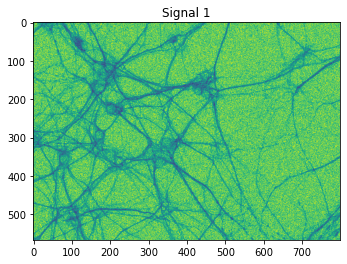

In [8]:
plt.imshow(img2)
plt.title('Signal 1')

Text(0.5, 1.0, 'Signal 2')

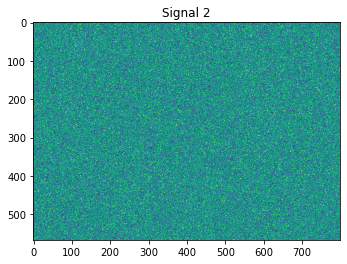

In [9]:
plt.imshow(img1)
plt.title('Signal 2')